In [5]:
!pip install mecab-ko-msvc mecab-ko-dic-msvc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 MB 8.8 MB/s eta 0:00:00


In [99]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import MeCab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score

In [100]:
import warnings
warnings.filterwarnings(action = 'ignore')

In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
df = pd.read_csv('/content/drive/MyDrive/esg 프로젝트/csv/우리은행.csv')
df = df.rename(columns={'기사날짜': 'date', '기사내용': 'content'})
# 만약 시간 데이터 열이 문자열 형식이라면, 날짜/시간 형식으로 변환
df['date'] = pd.to_datetime(df['date'])

# 'time_column'을 기준으로 오름차순으로 정렬
df = df.sort_values(by='date', ascending=True)

In [103]:
df

,Unnamed: 0,date,기사제목,네이버 뉴스 url,content,감정분석,Unnamed: 1
46,46.0,2021-10-01,새 수익원으로 '콕'…가상화폐 수탁사업에 꽂힌 은행(종합),https://n.news.naver.com/mnews/article/277/000...,"KB국민·신한·우리·NH농협은행, 커스터디 사업 진출신규 먹거리 주목…수수료 창출 ...",긍정,NaN
29,29.0,2021-10-01,"'중소형 첫 녹색금융' 금강수계관리기금, 우리은행서 맡아",https://n.news.naver.com/mnews/article/001/001...,"금강수계관리위원회, 주거래은행 업무 계약 체결대청호 물비늘 전망대[연합뉴스 자료 사...",긍정,NaN
20,20.0,2021-10-01,화천대유 사건 직간접 관련사업 난항… 공모 취소에 이어 중도금 대출도 불투명,https://n.news.naver.com/mnews/article/366/000...,대장동 도시개발 특혜의혹이 불거지면서 화천대유나 성남도시개발공사 등과 관련 있는 사...,부정,NaN
10,10.0,2021-10-01,"금감원, 우리금융지주·우리은행 종합검사 돌입(종합)",https://n.news.naver.com/mnews/article/001/001...,5대 지주·은행 중 마지막…빨라야 11월 시작할 듯 사모펀드 사태·내부통제 부실 등...,부정,NaN
13,13.0,2021-10-01,"우리은행, 분리수거함 설치하고 저탄소 식단 바꾸고",https://n.news.naver.com/mnews/article/031/000...,생활 속 친환경 실천…ESG경영 강화우리은행이 생활 속 친환경 실천을 통해 ESG(...,긍정,NaN
...,...,...,...,...,...,...,...
2338,37.0,2023-09-28,은행권 “이동점포서 신권 바꾸세요”,https://n.news.naver.com/mnews/article/030/000...,은행권이 임시공휴일을 포함한 추석 연휴 기간 고객 편의를 제고하기 위해 이동점포 운...,긍정,NaN
2396,95.0,2023-09-28,"""예금이나 대출 만기일이 연휴라면""…추석 금융거래 주의사항은",https://n.news.naver.com/mnews/article/003/001...,[서울=뉴시스] 최진석 기자 = 추석 연휴를 하루 앞둔 27일 오전 서울역에서 귀성...,중립,NaN
2344,43.0,2023-09-29,상품 가짓수 못 갖춘 인터넷전문은행의 게으른 혁신 [분석+],https://n.news.naver.com/mnews/article/665/000...,더스쿠프 마켓분석 국내 은행 뱅킹앱 보고서첫번째 지표➊ 금융상품 다양성 서경대 M...,긍정,NaN
2334,33.0,2023-09-30,추석에 받은 용돈…이색 예·적금은 어때?,https://n.news.naver.com/mnews/article/648/000...,인뱅 최대 4%대 고금리 예·적금…청소년층에 큰 인기시중은행들도 MZ 사로잡기…다양...,긍정,NaN


In [104]:
def mecab_tokenizer(text):
    # 입력이 문자열이 아닐 경우 빈 리스트 반환
    if not isinstance(text, str):
        return []

    mecab = MeCab.Tagger()
    parsed = mecab.parse(text)
    words = []
    for line in parsed.split('\n'):
        if '\t' in line:
            word, tag = line.split('\t')[0], line.split('\t')[1].split(',')[0]
            if tag in ['NNG', 'NNP', 'VV', 'VA', 'MAG'] and len(word) > 1:
                words.append(word)
    return words

In [105]:
def calculate_similarity(text1, text2):
    tokens1 = set(mecab_tokenizer(text1))
    tokens2 = set(mecab_tokenizer(text2))
    if not tokens1 or not tokens2:
        return 0
    return len(tokens1.intersection(tokens2)) / len(tokens1)

In [48]:
def remove_similar_texts(df, threshold=0.8):
    # 가장 최근 날짜로부터 일주일 전의 날짜를 계산
    one_week_ago = df['date'].max() - pd.Timedelta(days=7)

    # 일주일 전부터 현재까지의 데이터를 필터링
    recent_df = df[df['date'] >= one_week_ago]

    remove_indices = set()

    # 필터링된 데이터프레임에 대해 유사성 검사 수행
    for i, text1 in enumerate(recent_df['content']):
        for j, text2 in enumerate(recent_df['content']):
            if i != j and i not in remove_indices and j not in remove_indices:
                similarity = calculate_similarity(text1, text2)
                if similarity >= threshold:
                    remove_indices.add(recent_df.index[j])

    # 유사한 텍스트가 포함된 행을 제거
    return df.drop(list(remove_indices))

In [106]:
df = df.drop(df.columns[[0, -1]], axis=1)

In [107]:
df= remove_similar_texts(df)

In [108]:
df

,date,기사제목,네이버 뉴스 url,content,감정분석
46,2021-10-01,새 수익원으로 '콕'…가상화폐 수탁사업에 꽂힌 은행(종합),https://n.news.naver.com/mnews/article/277/000...,"KB국민·신한·우리·NH농협은행, 커스터디 사업 진출신규 먹거리 주목…수수료 창출 ...",긍정
29,2021-10-01,"'중소형 첫 녹색금융' 금강수계관리기금, 우리은행서 맡아",https://n.news.naver.com/mnews/article/001/001...,"금강수계관리위원회, 주거래은행 업무 계약 체결대청호 물비늘 전망대[연합뉴스 자료 사...",긍정
20,2021-10-01,화천대유 사건 직간접 관련사업 난항… 공모 취소에 이어 중도금 대출도 불투명,https://n.news.naver.com/mnews/article/366/000...,대장동 도시개발 특혜의혹이 불거지면서 화천대유나 성남도시개발공사 등과 관련 있는 사...,부정
10,2021-10-01,"금감원, 우리금융지주·우리은행 종합검사 돌입(종합)",https://n.news.naver.com/mnews/article/001/001...,5대 지주·은행 중 마지막…빨라야 11월 시작할 듯 사모펀드 사태·내부통제 부실 등...,부정
13,2021-10-01,"우리은행, 분리수거함 설치하고 저탄소 식단 바꾸고",https://n.news.naver.com/mnews/article/031/000...,생활 속 친환경 실천…ESG경영 강화우리은행이 생활 속 친환경 실천을 통해 ESG(...,긍정
...,...,...,...,...,...
2338,2023-09-28,은행권 “이동점포서 신권 바꾸세요”,https://n.news.naver.com/mnews/article/030/000...,은행권이 임시공휴일을 포함한 추석 연휴 기간 고객 편의를 제고하기 위해 이동점포 운...,긍정
2396,2023-09-28,"""예금이나 대출 만기일이 연휴라면""…추석 금융거래 주의사항은",https://n.news.naver.com/mnews/article/003/001...,[서울=뉴시스] 최진석 기자 = 추석 연휴를 하루 앞둔 27일 오전 서울역에서 귀성...,중립
2344,2023-09-29,상품 가짓수 못 갖춘 인터넷전문은행의 게으른 혁신 [분석+],https://n.news.naver.com/mnews/article/665/000...,더스쿠프 마켓분석 국내 은행 뱅킹앱 보고서첫번째 지표➊ 금융상품 다양성 서경대 M...,긍정
2334,2023-09-30,추석에 받은 용돈…이색 예·적금은 어때?,https://n.news.naver.com/mnews/article/648/000...,인뱅 최대 4%대 고금리 예·적금…청소년층에 큰 인기시중은행들도 MZ 사로잡기…다양...,긍정


In [91]:
# 데이터를 훈련 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['감정분석'], test_size=0.2, random_state=42)

In [92]:
# 2. 모델 훈련
model = make_pipeline(TfidfVectorizer(tokenizer=mecab_tokenizer), MultinomialNB())
model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(tokenizer=<function mecab_tokenizer at 0x7bfe242092d0>)),
                ('multinomialnb', MultinomialNB())])

In [93]:
# 3. 성능 평가
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

print(f'accuracy: {accuracy:.24}')
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

accuracy: 0.612500000000000044408921
Precision: 0.62
Recall: 0.61


In [54]:
df2 = pd.read_csv('/content/drive/MyDrive/esg 프로젝트/csv/현대차_2021-11.csv')
df2 = df2[['date','title','content']]
# 만약 시간 데이터 열이 문자열 형식이라면, 날짜/시간 형식으로 변환
df2['date'] = pd.to_datetime(df2['date'])

# 'time_column'을 기준으로 오름차순으로 정렬
df2 = df2.sort_values(by='date', ascending=True)

In [22]:
df2

,date,title,content
184,2021-11-01 11:04:00,"KB자산운용, 친환경 테마 ETF 강화…수소경제·기후변화 등 다양",KB자산운용이 친환경을 테마로 한 ETF(상장지수 펀드)을 연달아 내놓으면서 관련 ...
188,2021-11-01 14:00:00,[단독] 중국 교민사회 사분오열… 한국대사관 올림픽 어찌 치르나,내년 2월 베이징 동계올림픽을 100일 앞두고 주중(駐中) 한국대사관에 비상등이 켜...
26,2021-11-01 16:49:00,11월에 트래버스·말리부 사면 36개월 무이자… SM6는 200만원 할인,국내 자동차 5사가 11월 '코리아세일페스타' 기간을 맞아 다양한 판매 조건을 공개...
5,2021-11-01 17:34:00,반도체에 휘청거린 車판매..그랜저 선전에도 현대차·기아 20% 급감,국내 완성차업계를 덮친 차량용 반도체 공급대란 여파로 생산량 자체가 줄며 판매 급감...
82,2021-11-01 17:49:00,반도체난에 국내 완성차업계 10월 판매↓…내수 8개월째 역성장,"글로벌 판매도 4개월째 감소, 현대차 기아 한국GM 쌍용차 등 마이너스 르노삼성차만..."
...,...,...,...
100,2021-11-30 09:51:00,“1년 기다리라던 차 빨리 받을수 있나”…현대차 울산 공장 주말특근 돌입한다는데 [...,"토요일 전체 특근.""반도체 대란 이후 처음"" 특별연장근로로 일요일 특근도 나설 듯 ..."
185,2021-11-30 10:58:00,"한온시스템, 국내 첫 전기차 전용 열관리 시스템 공장 가동",자동차 열 에너지 관리 솔루션 기업 한온시스템이 국내 첫 전기차 전용 열관리 시스템...
156,2021-11-30 16:14:00,"밤 잠 설치는 그들 “올해 계약했는데, 전기차 보조금 똑같이 주겠지?” [손재철의 ...",순수 배터리 전기차(BEV) 수요가 늘면서 올해 전기차(EV)를 계약한 예비 차주들...
53,2021-11-30 17:16:00,"이동걸, 항공통합 심사지연 공정위에 교각살우 우 범하지 않아야","""나무를 보지말고 숲봐야 기업이 망하면 소비자 복지 증진 없어"" ""쌍용차 전기차 전..."


In [143]:
E_keywords = {'친환경', '물질', '기후', '발생', '요인', '화학', '배출', '생물', '온실가스', '오염', '보전', '생태', '탄소', '유해', '용수', '순환', '산림', '사용량', '부자재', '해양', '설비', '자연', '수자원', '폐수', '녹색', '사슬', '재생', '정량', '지역', '폐기', '배출권', '저탄소', '건강', '플라스틱', '인벤토리', '보호', '피해', '원료', '저감', '신재'}
S_keywords = {'위험', '규준', '모범', '공개', '참고', '문화', '의사', '요인', '체계', '개인', '안전', '공급', '발생', '제도', '효과', '피해', '가치', '소통', '파악', '구축', '리더십', '보건', '사항', '침해', '보장', '점검', '실사', '결과', '보상', '역할', '결함', '공유', '성장', '방침', '자유', '경제', '생활', '상호', '고용', '관계', '예방', '정기', '달성', '창출', '주체', '범위', '동반성', '부당', '균형', '형성', '규제', '보안', '강령', '연계', '감독', '저해', '권익', '부합', '표명', '자발', '개정', '안전성', '고충', '임금', '업무', '자율', '긍정', '증진', '이익', '정의', '특성', '투입', '근거', '유도', '적절', '해소', '조성', '인지', '뒷받침', '노사', '구조', '산업', '국내외', '근무', '수단', '남용', '관여', '건강', '차별', '기반', '수집', '전달', '협의', '유형', '인력', '대내외', '상이', '정량', '모델', '중대', '계층', '완화', '정당', '관점', '선택', '금지', '선제', '방지', '전문', '잠재', '중심', '질서', '조건', '합리', '비용', '이용', '생산', '조사', '확립', '가격', '메커니즘', '대책', '접근성', '취약', '성별', '조치', '사고', '우려', '실질', '불공정', '시행', '비율', '재해', '기업지배구조', '경영진', '변화', '채널', '자사', '절차', '부정', '행위', '외부', '가이드라인', '임직원', '부서', '구성', '사례', '프로그램', '목적', '처리', '구체', '기본', '설정', '측면', '부여'}
G_keywords = {'감사', '이사', '주주', '위원회', '지배', '모범', '규준', '사외', '기업지배구조', '총회', '선임', '규정', '중대', '내용', '관계', '직무', '재무', '후보', '기능', '경영자', '결의', '보수', '독립성', '전문', '의사', '권고', '주식', '금지', '행사', '회계', '위원', '소통', '이익', '승계', '이사회', '공개', '법령', '의결권', '보상', '임원', '보호', '사유', '환경', '지배주', '추천', '다양', '부서', '노력', '자본', '정기', '참석', '개최', '책임자', '포함', '임직원', '윤리', '대표', '설치', '의견', '투명', '제도', '행위', '공정', '권리', '변화', '정관', '마련', '정책', '회의', '유지', '이용', '영업', '반대', '보고', '자격', '보장', '타당', '제정', '영향', '매수', '제한', '안건', '일반', '판단', '개정', '과도', '사전', '보고서', '적정', '직접', '정확', '투자', '비밀', '교육', '의안', '목적', '승인', '자신', '과정', '해임', '자료', '집행', '자기', '독립', '이해관계', '상충', '합병', '분리', '내역', '담당', '방법', '침해', '발생', '합리', '자산', '설명', '활용', '의미', '관행', '근거', '회의록', '제시', '용이', '방향', '작성', '전문가', '위임', '집단', '의장', '예측', '요청', '활성', '자문', '훼손', '인수', '지급', '상정', '존중', '지정', '일치', '자기거래', '양수', '상장', '지식', '시장', '법인', '투표', '부여', '논의', '용역', '소유', '추구', '주의', '특수', '이상', '지양', '영향력', '계열사', '법률', '조성', '인과', '사내', '연간', '손해', '부당', '전원', '개별', '토의', '명문화', '상세', '보유', '공유', '신속', '수단', '가진', '접근', '전자', '적시', '기재', '장소', '방안', '우려', '보험', '투입', '실효', '원활', '외국인', '전체', '개인', '명확', '일정', '성장', '가입', '채권자', '항목'}


In [139]:
# 데이터프레임에서 유사도가 높은 텍스트 제거
df3 = remove_similar_texts(df2)

In [56]:
def find_most_similar_category(text):
    # 텍스트를 토큰화
    tokens = set(mecab_tokenizer(text))

    # 각 카테고리와의 유사도 계산
    E_similarity = len(E_keywords.intersection(tokens))
    S_similarity = len(S_keywords.intersection(tokens))
    G_similarity = len(G_keywords.intersection(tokens))

    # 가장 유사도가 높은 카테고리 찾기
    similarities = {'E': E_similarity, 'S': S_similarity, 'G': G_similarity}
    most_similar_category = max(similarities, key=similarities.get, default='X')

    # 유사도가 0이면 'X' 반환
    if similarities[most_similar_category] == 0:
        return 'X'
    return most_similar_category

In [131]:
def calculate_sentence_category_percentages(text):
    sentences = text.split('.')
    category_counts = {'E': 0, 'S': 0, 'G': 0}

    for sentence in sentences:
        if sentence.strip():
            category = find_most_similar_category(sentence)
            if category in category_counts:
                category_counts[category] += 1

    total_sentences = len(sentences)

    category_percentages = {}
    if total_sentences > 0:
        esg_total = 0
        for k, v in category_counts.items():
            percentage = (v / total_sentences) * 100
            category_percentages[k] = round(percentage, 2)
            esg_total += v
        category_percentages['ESG_Total'] = round((esg_total / total_sentences) * 100, 2)
    else:
        for k in category_counts:
            category_percentages[k] = 0
        category_percentages['ESG_Total'] = 0

    return category_percentages

In [132]:
def add_category_percentages_to_df(df):
    for index, row in df.iterrows():
        percentages = calculate_sentence_category_percentages(row['content'])
        for category, pct in percentages.items():
            df.at[index, f'{category} %'] = pct

    return df

In [137]:
def count_keywords_in_sentence(sentence, category, E_keywords, S_keywords, G_keywords):
    # 각 카테고리에 해당하는 키워드 세트를 선택합니다.
    if category == 'E':
        keywords = E_keywords
    elif category == 'S':
        keywords = S_keywords
    else:  # category == 'G'
        keywords = G_keywords

    # 문장에서 각 키워드의 출현 횟수를 계산합니다.
    keyword_count = 0
    for keyword in keywords:
        if keyword in sentence:
            keyword_count += 1

    return keyword_count

In [141]:
def count_keywords_in_sentence(sentence, category, E_keywords, S_keywords, G_keywords):
    # 카테고리에 따라 적절한 키워드 세트를 선택
    keywords = E_keywords if category == 'E' else S_keywords if category == 'S' else G_keywords

    # 문장에서 키워드 출현 횟수 계산
    return sum(keyword in sentence for keyword in keywords)

# 가장 키워드가 밀집된 ESG 관련 문장 추출 함수
def extract_most_keyword_dense_esg_sentence(text, E_keywords, S_keywords, G_keywords):
    sentences = text.split('.')
    max_keywords = 0
    most_keyword_dense_sentence = ""

    for sentence in sentences:
        if sentence.strip():
            category = find_most_similar_category(sentence)
            if category in ['E', 'S', 'G']:
                keywords_count = count_keywords_in_sentence(sentence, category, E_keywords, S_keywords, G_keywords)
                if keywords_count > max_keywords:
                    max_keywords = keywords_count
                    most_keyword_dense_sentence = sentence.strip()

    return most_keyword_dense_sentence

In [142]:
def add_category_percentages_and_esg_sentence_to_df(df, E_keywords, S_keywords, G_keywords):
    for index, row in df.iterrows():
        percentages = calculate_sentence_category_percentages(row['content'])
        for category, pct in percentages.items():
            df.at[index, f'{category} %'] = pct

        esg_sentence = extract_most_keyword_dense_esg_sentence(row['content'], E_keywords, S_keywords, G_keywords)
        df.at[index, 'ESG_Sentence'] = esg_sentence

    return df

In [145]:
# 새로운 데이터에 대한 예측 수행
df3['감정분석'] = model.predict(df3['content'])
df3['ESG'] = df3['content'].apply(find_most_similar_category)
df3 = add_category_percentages_and_esg_sentence_to_df(df3,E_keywords,S_keywords,G_keywords)

In [146]:
df3

,date,title,content,감정분석,ESG,E %,S %,G %,ESG_Total %,ESG_Sentence
184,2021-11-01 11:04:00,"KB자산운용, 친환경 테마 ETF 강화…수소경제·기후변화 등 다양",KB자산운용이 친환경을 테마로 한 ETF(상장지수 펀드)을 연달아 내놓으면서 관련 ...,중립,G,15.38,7.69,25.64,48.72,KB자산운용은 1일 'KBSTAR 수소경제테마 ETF''KBSTAR 글로벌클린에너지...
188,2021-11-01 14:00:00,[단독] 중국 교민사회 사분오열… 한국대사관 올림픽 어찌 치르나,내년 2월 베이징 동계올림픽을 100일 앞두고 주중(駐中) 한국대사관에 비상등이 켜...,중립,G,17.65,5.88,55.88,79.41,심지어 이들 지역회장들은 지난 10월 11일 장하성 주중대사와 김성곤 재외동포재단 ...
26,2021-11-01 16:49:00,11월에 트래버스·말리부 사면 36개월 무이자… SM6는 200만원 할인,국내 자동차 5사가 11월 '코리아세일페스타' 기간을 맞아 다양한 판매 조건을 공개...,긍정,S,0.00,35.71,12.50,48.21,또 직계 존 비속이 쏘나타를 보유하고 있거나 출고이력(영업용 포함)이 있는 고객이 ...
5,2021-11-01 17:34:00,반도체에 휘청거린 車판매..그랜저 선전에도 현대차·기아 20% 급감,국내 완성차업계를 덮친 차량용 반도체 공급대란 여파로 생산량 자체가 줄며 판매 급감...,긍정,G,2.38,19.05,14.29,35.71,"현대차그룹 관계자는 ""반도체 부품 수급 차질로 인한 생산 차질 및 공급 제약이 이어..."
82,2021-11-01 17:49:00,반도체난에 국내 완성차업계 10월 판매↓…내수 8개월째 역성장,"글로벌 판매도 4개월째 감소, 현대차 기아 한국GM 쌍용차 등 마이너스 르노삼성차만...",중립,S,3.51,12.28,5.26,21.05,신종 코로나바이러스 감염증(코로나19) 확산 탓에 심화된 글로벌 차량용 반도체 공급...
...,...,...,...,...,...,...,...,...,...,...
100,2021-11-30 09:51:00,“1년 기다리라던 차 빨리 받을수 있나”…현대차 울산 공장 주말특근 돌입한다는데 [...,"토요일 전체 특근.""반도체 대란 이후 처음"" 특별연장근로로 일요일 특근도 나설 듯 ...",긍정,S,0.00,50.00,30.00,80.00,특별연장근로란 갑작스러운 문제를 해결하거나 부득이하게 업무량을 늘리기 위해 근로자 ...
185,2021-11-30 10:58:00,"한온시스템, 국내 첫 전기차 전용 열관리 시스템 공장 가동",자동차 열 에너지 관리 솔루션 기업 한온시스템이 국내 첫 전기차 전용 열관리 시스템...,긍정,G,0.00,50.00,16.67,66.67,"성민석 한온시스템 최고경영자 대표집행임원은 ""전략적 거점인 경주공장을 통해 전기차 ..."
156,2021-11-30 16:14:00,"밤 잠 설치는 그들 “올해 계약했는데, 전기차 보조금 똑같이 주겠지?” [손재철의 ...",순수 배터리 전기차(BEV) 수요가 늘면서 올해 전기차(EV)를 계약한 예비 차주들...,중립,G,0.00,38.89,22.22,61.11,"그러면서 이 후보는 자신의 페이스북에 ""정부가 차량가격을 보조하기 위해 보조금을 지..."
53,2021-11-30 17:16:00,"이동걸, 항공통합 심사지연 공정위에 교각살우 우 범하지 않아야","""나무를 보지말고 숲봐야 기업이 망하면 소비자 복지 증진 없어"" ""쌍용차 전기차 전...",중립,G,3.08,29.23,33.08,65.38,"쌍용차 인수자로 낙점된 에디슨모터스에 대한 신규 대출에 대해선 ""공식적인 자금 지원..."


In [ ]:
df.to_csv('현대차_2111(감정분석).csv', index=False)

In [ ]:
from joblib import dump

# 모델을 파일로 저장
dump(model, 'model_현대차.joblib')

['model_현대차.joblib']

In [97]:
import matplotlib.pyplot as plt
df3['Combined'] = df3['ESG'] + "-" + df3['감정분석']
frequency = df3['Combined'].value_counts()

In [98]:
frequency

G-긍정    60
G-중립    59
S-긍정    48
S-중립    18
G-부정     5
S-부정     3
Name: Combined, dtype: int64

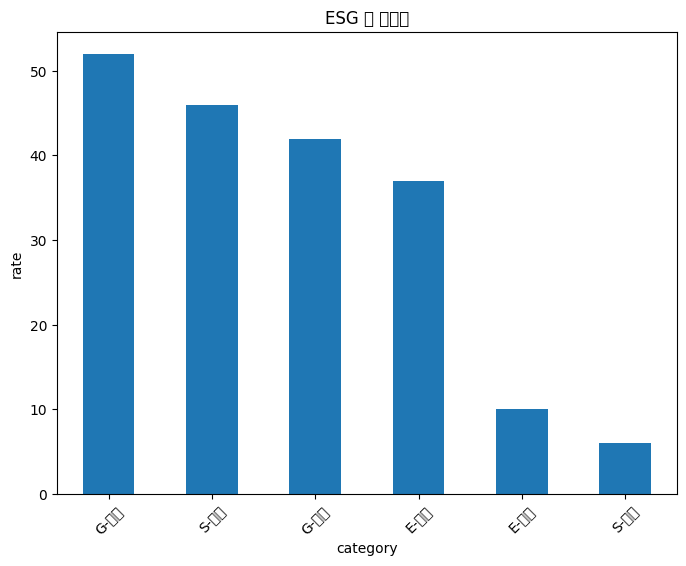

In [ ]:
# 빈도를 막대 그래프로 나타내기
plt.figure(figsize=(8, 6))
frequency.plot(kind='bar')
plt.title('ESG 및 긍부정')
plt.xlabel('category')
plt.ylabel('rate')
plt.xticks(rotation=45)
plt.show()